In [20]:
import tensorflow as tf
from time import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from local.lib import mlutils
%matplotlib inline

## Imágenes desde ficheros

ref https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

### descargamos imágenes de dos queries en google

In [21]:
!pip install google_images_download

In [105]:
downloads = "tmp/downloads"
traintest_imgs = "tmp/imgs"

train_pct = .7

In [106]:
!rm -rf $downloads
!mkdir -p $downloads

cfg="""
{
    "Records": [
        {
            "keywords": "bike",
            "format": "jpg",
            "limit": 50,
            "type": "photo",
            "size": "medium",
            "output_directory": "%s"
        },
        {
            "keywords": "motorbike",
            "format": "jpg",
            "limit": 50,
            "type": "photo",
            "size": "medium", 
            "output_directory": "%s"
        }
    ]
}
"""%(downloads, downloads)

In [107]:
with open(downloads+"/cfg.txt", "w") as f:
    f.write(cfg)

In [108]:
!googleimagesdownload --config_file $downloads/cfg.txt


Item no.: 1 --> Item name = bike
Evaluating...
Starting Download...
Completed Image ====> 1.yeti-sb165-action-tested-logo-1564087725.jpg
Completed Image ====> 2.rad-power-rad-city-0126-tested-1554833677.jpg
Completed Image ====> 3.Kalosse-dirt-bike-ATV-bicicleta-de-monta-a-cuesta-abajo-DH-bicicleta-de-monta-a-26.jpg
Completed Image ====> 4.143646.jpg
Completed Image ====> 5.LLR_Santiago-61_abd5aa2d-623d-48ff-973a-f7577d156bfd_grande.jpg
Completed Image ====> 6.s-works-creo-sl-lead-image-1563287797.jpg
Completed Image ====> 7.61VXCJEHEyL._SX466_.jpg
Completed Image ====> 8.51YftDZJP3L._SR600%2C315_PIWhiteStrip%2CBottomLeft%2C0%2C35_PIAmznPrime%2CBottomLeft%2C0%2C-5_PIStarRatingFOURANDHALF%2CBottomLeft%2C360%2C-6_SR600%2C315_SCLZZZZZZZ_.jpg
Completed Image ====> 9.1626283_original_1.jpg
Completed Image ====> 10.berry_bikecheck1.jpg
Completed Image ====> 11.website_testbericht_sam2_6.8_slider_mobile_3.jpg
Completed Image ====> 12.VERDE-pepita-fuerteventura.jpg
Completed Image ====> 13.ma

### revisamos las imágenes y eliminamos las defectuosas

In [109]:
from skimage import io
files = !find $downloads -type f
for fname in files:
    if fname!=downloads+"/cfg.txt":
        print (".", end="")
        try:
            io.imread(fname)
        except:
            print ("\nremoving",fname,"as cannot be read\n")
            !rm $fname

...
removing tmp/downloads/bike/31.2020-GR300-Complete-ML-BlackDecals-Force1-StansGrail-1500x1000-01__28670.1569446534.jpg as cannot be read

.......................................................................................
removing tmp/downloads/motorbike/13.E-BIKE-Munro-2-0-Electric-motorbike-48V-lithium-battery-Luxury-smart-electric-motorcycle-26-inch.jpg as cannot be read

......
removing tmp/downloads/motorbike/3.Hcgwork-Junyue-Black-Warrior-Electric-Motorcycle-Motorbike-Monkey-Bike-Msx-Monster-Grom-Max-120km-h-Free.jpg as cannot be read

....


### organizamos las imágenes en train y en test

In [110]:
classdirs = !find $downloads -type d
classdirs = [i.split("/")[-1] for i in classdirs if i!=downloads]
print (classdirs)

['bike', 'motorbike']


In [111]:
!rm -rf $traintest_imgs

In [112]:
for classdir in classdirs:
    print (classdir)
    print ("    splitting files ... ", end=" ")
    files = !find $downloads/$classdir -type f
    files = np.r_[files]
    n_train = int(len(files)*train_pct)
    files = np.random.permutation(files)
    files_train = files[:n_train]
    files_test  = files[n_train:]
    !mkdir -p $traintest_imgs/train/$classdir
    !mkdir -p $traintest_imgs/test/$classdir
    print ("copying files")
    for f in files_train:
        !cp $f $traintest_imgs/train/$classdir
    for f in files_test:
        !cp $f $traintest_imgs/test/$classdir

bike
    splitting files ...  copying files
motorbike
    splitting files ...  copying files


### sanity check 1

In [113]:
for classdir in classdirs:
    print (classdir)
    files = !find  $traintest_imgs/train/$classdir -type f
    print ("      ",len(files), "train images")
    files = !find  $traintest_imgs/test/$classdir -type f
    print ("      ",len(files), "test images")

bike
       34 train images
       15 test images
motorbike
       33 train images
       15 test images


### sanity check 2

see [ImageGenerator](https://keras.io/preprocessing/image/)

In [114]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [115]:
datagen = ImageDataGenerator(rescale=1./255, fill_mode='nearest')
batch_size = 10
img_size = 64
train_generator_fn = lambda: datagen.flow_from_directory(
        traintest_imgs+"/train",  # this is the target directory
        target_size=(img_size, img_size),  # all images will be resized to 150x150
        batch_size=batch_size,
        interpolation = "bilinear",
        class_mode='binary') 

test_generator_fn = lambda: datagen.flow_from_directory(
        traintest_imgs+"/test",  # this is the target directory
        target_size=(img_size, img_size),  # all images will be resized to 150x150
        batch_size=batch_size,
        interpolation = "bilinear",
        class_mode='binary') 

Found 67 images belonging to 2 classes.


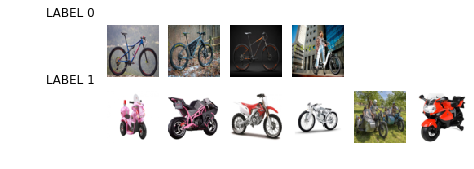

In [118]:
for imgs,labels in train_generator_fn():
    if np.random.random()>.5:
        break
mlutils.show_labeled_image_mosaic(imgs, labels)

### train keras!!!

In [119]:
def get_conv_model_A(num_classes, img_size=32, compile=True):
    tf.reset_default_graph()
    tf.keras.backend.clear_session()
    print ("using",num_classes,"classes")
    inputs = tf.keras.Input(shape=(img_size,img_size,3), name="input_1")
    layers = tf.keras.layers.Conv2D(10,(5,5), activation="relu")(inputs)
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dense(16, activation=tf.nn.relu)(layers)
    layers = tf.keras.layers.Dropout(0.2)(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    return model

In [120]:
num_classes = len(classdirs)
model = get_conv_model_A(num_classes, img_size=img_size)

model.fit_generator(
        train_generator_fn(),
        steps_per_epoch=1000 // batch_size,
        epochs=3,
        validation_data=test_generator_fn(),
        validation_steps=400 // batch_size)


using 2 classes
Found 67 images belonging to 2 classes.
Found 30 images belonging to 2 classes.
Epoch 1/3
100/100 [==============================] - 23s 231ms/step - loss: 0.7134 - acc: 0.4906 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 2/3
100/100 [==============================] - 24s 238ms/step - loss: 0.6931 - acc: 0.4942 - val_loss: 0.6931 - val_acc: 0.5025
Epoch 3/3
100/100 [==============================] - 25s 247ms/step - loss: 0.6931 - acc: 0.5063 - val_loss: 0.6933 - val_acc: 0.4950


### predictions

In [121]:
def show_preds(x, preds):
    for i  in np.random.permutation(range(len(preds)))[:4]:
        plt.figure(figsize=(5,2.5))
        plt.subplot(122)
        plt.imshow(x[i])
        plt.axis("off")
        plt.subplot(121)
        plt.bar(np.arange(2), preds[i], color="blue", alpha=.5, label="prediction")
        plt.bar(np.arange(2), np.eye(2,2)[int(y[i])], color="red", alpha=.5, label="label")
        plt.xticks(range(2), range(2), rotation="vertical");
        plt.xlim(-.5,1.5);
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, +1.35),ncol=5)


In [122]:
from importlib import reload
reload(mlutils)

<module 'local.lib.mlutils' from '/home/rlx/Dropbox/teaching/machine-learning/DiplomadoEPM_2019/Modulo2/local/lib/mlutils.py'>

Found 30 images belonging to 2 classes.


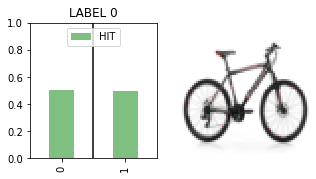

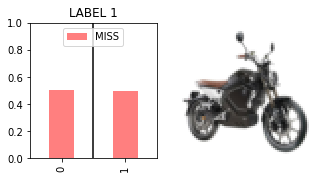

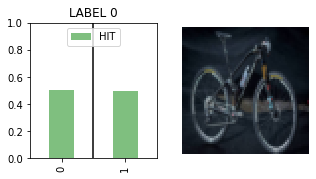

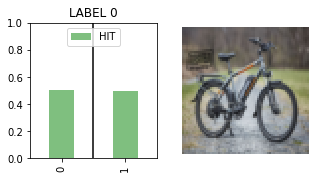

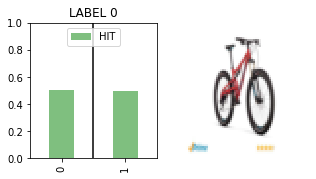

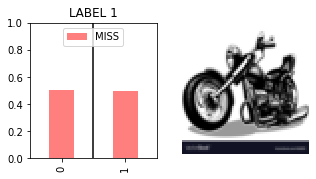

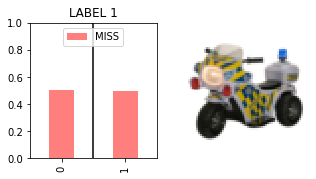

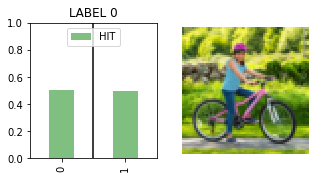

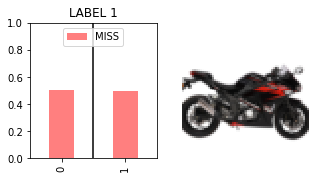

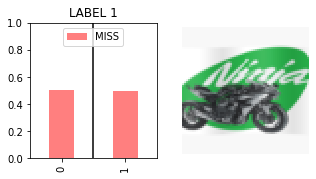

In [123]:
for x,y in test_generator_fn():
    if np.random.random()>.7:
        break
        
preds = model.predict(x)
mlutils.show_preds(x, y, preds)